In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import numpy as np

%load_ext autoreload
%autoreload 2
from data_loader import MessageDataset

In [2]:
PATH='./telegram_fetch/texts/maria_1ua'
#PATH='./telegram_fetch/texts/elvina'

PATH='./telegram_fetch/tmp.dump'

In [3]:
dataset = MessageDataset(PATH)

(70463, 13920)


In [4]:
x,y = dataset[0]
N = x.shape[-1]
print(np.sum(x),np.sum(y))
print(x.shape,y.shape)
print(f"Dimension size {N}")
print(f"Dataset length {len(dataset)}")

1.0 3.0
(13920,) (13920,)
Dimension size 13920
Dataset length 70463


In [5]:
class Encoder(nn.Module):
    def __init__(self, input_dim, out = 300):
        super().__init__()
        self.inp = input_dim
        self.out = out
        N_layers = 2
        ratio = np.power(input_dim/out, 1/N_layers)
        mult = int(ratio*out)
        print(mult)
        
        self.dense1 = nn.Linear(self.inp, mult )
        self.dense2 = nn.Linear(mult, out )
        
    def forward(self,x):
        x = F.relu(self.dense1(x))
        x = self.dense2(x)
        return x
        

In [6]:
class Decoder(nn.Module):
    def __init__(self, out, input_dim=300):
        super(Decoder, self).__init__()
        self.inp = input_dim
        self.out = out
        N_layers = 2
        ratio = np.power(input_dim/out, 1/N_layers)
        mult = int(ratio*out)
        
        self.dense1 = nn.Linear(self.inp, mult )
        self.dense2 = nn.Linear(mult, out )
        
    def forward(self,x):
        x = F.relu(self.dense1(x))
        x = self.dense2(x)
        return x

In [7]:
enc = Encoder(N)
dec = Decoder(N)
print("encoder",enc)
print("decoder",dec)


2043
encoder Encoder(
  (dense1): Linear(in_features=13920, out_features=2043, bias=True)
  (dense2): Linear(in_features=2043, out_features=300, bias=True)
)
decoder Decoder(
  (dense1): Linear(in_features=300, out_features=2043, bias=True)
  (dense2): Linear(in_features=2043, out_features=13920, bias=True)
)


In [8]:
class Hourglass(nn.Module):
    def __init__(self, N, embd=300):
        super().__init__()
        self.enc = Encoder(N, embd)
        self.dec = Decoder(N, embd)
    def forward(self,x):
        x = self.enc(x)
        x = self.dec(x)
        return x


In [59]:
coder = Hourglass(N, embd=30)
device = torch.device('cuda:0')
#coder.to(device)
def param_cnt(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"parameters count {param_cnt(coder)}")
coder

646
parameters count 18038642


Hourglass(
  (enc): Encoder(
    (dense1): Linear(in_features=13920, out_features=646, bias=True)
    (dense2): Linear(in_features=646, out_features=30, bias=True)
  )
  (dec): Decoder(
    (dense1): Linear(in_features=30, out_features=646, bias=True)
    (dense2): Linear(in_features=646, out_features=13920, bias=True)
  )
)

In [60]:
import torch.optim as optim

criterion = nn.BCEWithLogitsLoss()
opt = optim.SGD(coder.parameters(), lr = 0.1, momentum=.39)

In [61]:
import tqdm, time

In [62]:
torch.cuda.set_device(0)
coder.cuda()

Hourglass(
  (enc): Encoder(
    (dense1): Linear(in_features=13920, out_features=646, bias=True)
    (dense2): Linear(in_features=646, out_features=30, bias=True)
  )
  (dec): Decoder(
    (dense1): Linear(in_features=30, out_features=646, bias=True)
    (dense2): Linear(in_features=646, out_features=13920, bias=True)
  )
)

In [63]:
dataloader = DataLoader(dataset, batch_size=100)

In [64]:
start = time.time()
for epoch in range(10):
    running_loss = 0.0
    for i, data in (enumerate(dataloader,0)):
        word, window = data
        word, window = torch.Tensor(word.float()), torch.Tensor(window.float())
        
        opt.zero_grad()
        outputs = coder(word.cuda())
        loss = criterion(outputs, window.cuda())
        loss.backward()
        opt.step()
        running_loss += loss.item()
        if i % 20 == 0:
            delta_t = time.time()-start
            print(f"[{epoch}, {i}] {np.round(delta_t,3)} loss: {running_loss/20}")
            start = time.time()
            running_loss = 0.0
        

[0, 0] 0.153 loss: 0.03466673493385315
[0, 20] 3.075 loss: 0.6932003289461136
[0, 40] 3.0 loss: 0.6929247349500656
[0, 60] 3.009 loss: 0.6926464468240738
[0, 80] 3.026 loss: 0.692369458079338
[0, 100] 3.081 loss: 0.6920923560857772
[0, 120] 2.876 loss: 0.6918143928050995
[0, 140] 2.775 loss: 0.6915374219417572
[0, 160] 2.823 loss: 0.6912584483623505
[0, 180] 2.832 loss: 0.6909774601459503
[0, 200] 2.881 loss: 0.6906967461109161
[0, 220] 2.888 loss: 0.6904120057821274
[0, 240] 2.791 loss: 0.6901266872882843
[0, 260] 2.814 loss: 0.6898395150899888
[0, 280] 3.137 loss: 0.6895488679409028
[0, 300] 2.85 loss: 0.6892560422420502
[0, 320] 4.702 loss: 0.6889588892459869
[0, 340] 4.993 loss: 0.6886607497930527
[0, 360] 5.101 loss: 0.6883549094200134
[0, 380] 5.581 loss: 0.6880465805530548
[0, 400] 5.108 loss: 0.6877345770597458
[0, 420] 4.67 loss: 0.6874177694320679
[0, 440] 4.833 loss: 0.6870943605899811
[0, 460] 5.104 loss: 0.6867661058902741
[0, 480] 5.547 loss: 0.6864318579435349
[0, 500] 5

KeyboardInterrupt: 

In [73]:
hot = dataset._encoder
x =  hot.transform(np.array(list(dataset.words)[:1000]).reshape(-1,1)).todense()
words =  dataset._encoder.inverse_transform(x)
coded = coder.enc(torch.Tensor(x).cuda())
X = coded.detach().cpu().numpy()


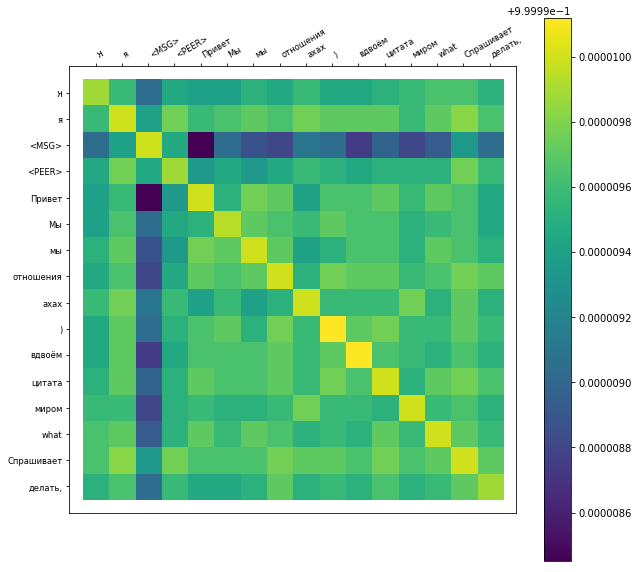

In [67]:
from utils.corrplot import corrplot
words = ['Я','я', "<MSG>","<PEER>","Привет",
         "Мы",
         "мы",
         "отношения",
         "ахах",
         ")",
         "вдвоём",
         "цитата",
         "миром",
         "what",
         "Спрашивает",
         "делать,",
        ]
x =  hot.transform(np.array(words).reshape(-1,1)).todense()
coded = coder.enc(torch.Tensor(x).cuda())
X = coded.detach().cpu().numpy()

X_unit = np.array([x/np.linalg.norm(x) for x in X])
mtx = []
for i in X_unit:
    mtx.append(
    [i.dot(j) for j in X_unit]
    )
mtx=np.array(mtx)
    
plt.figure(figsize=(10,10))
f = corrplot(mtx,None, words)


In [68]:

from sklearn import manifold
import matplotlib.pyplot as plt
import matplotlib.cm as cm


In [69]:
tsne = manifold.TSNE(n_components=2, init='pca', n_iter=1000, perplexity=500)


In [74]:
Y = tsne.fit_transform(X)

In [75]:
def tsne_plot_2d(label, embeddings, words=[], a=1):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, 1))
    x = embeddings[:,0]
    y = embeddings[:,1]
    plt.scatter(x, y, c=colors, alpha=a, label=label, s=1)
    for i, word in enumerate(words):
        plt.annotate(word, alpha=0.3, xy=(x[i], y[i]), xytext=(5, 2), 
                     textcoords='offset points', ha='right', va='bottom', size=4)
    plt.legend(loc=4)
    plt.grid(True)
    plt.savefig(f"figures/t-sne_{label}.pdf")
    plt.show()
    

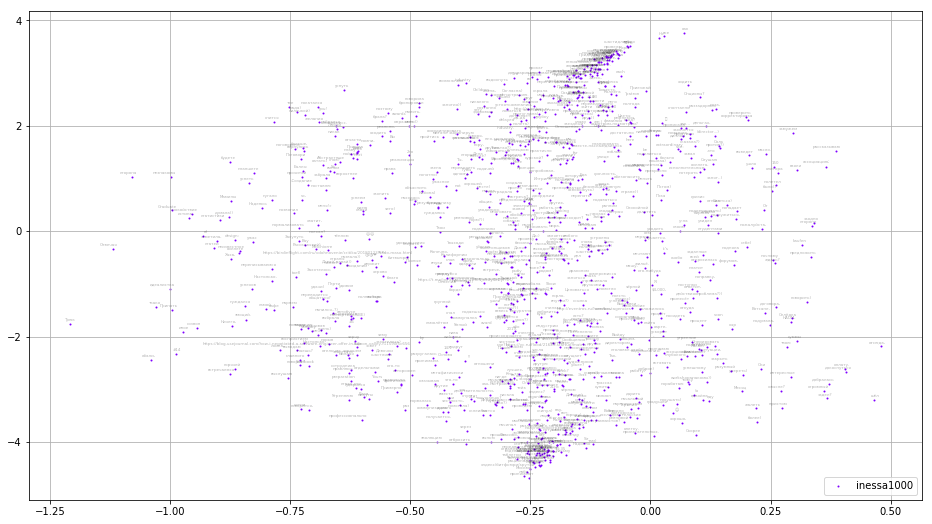

In [76]:

tsne_plot_2d('inessa1000', Y, words.reshape(-1))

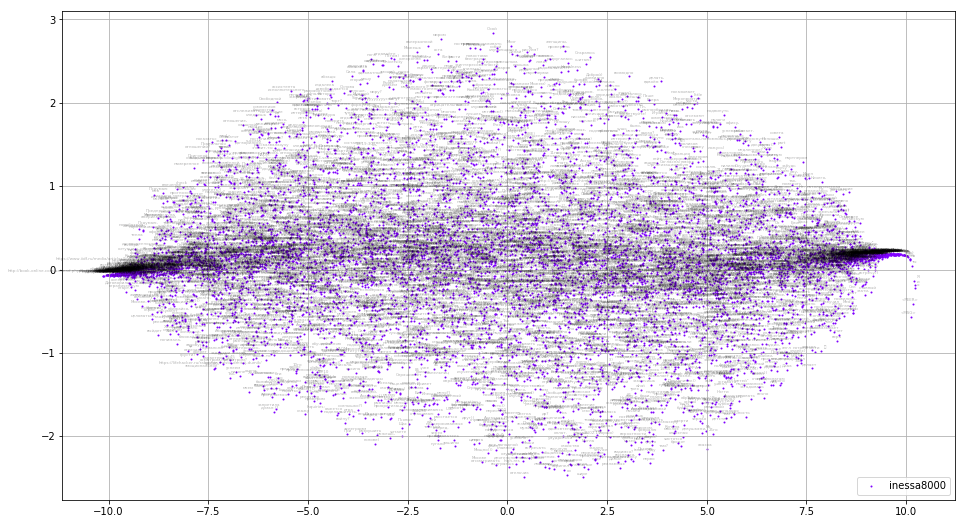

In [27]:

tsne_plot_2d('inessa8000', Y, words.reshape(-1))

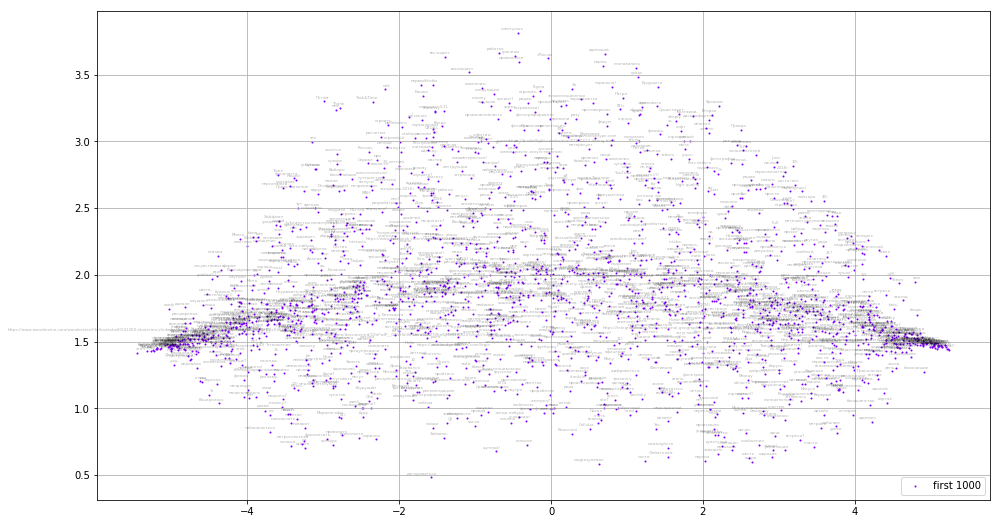

In [135]:
tsne_plot_2d('first 1000', Y, words.reshape(-1))

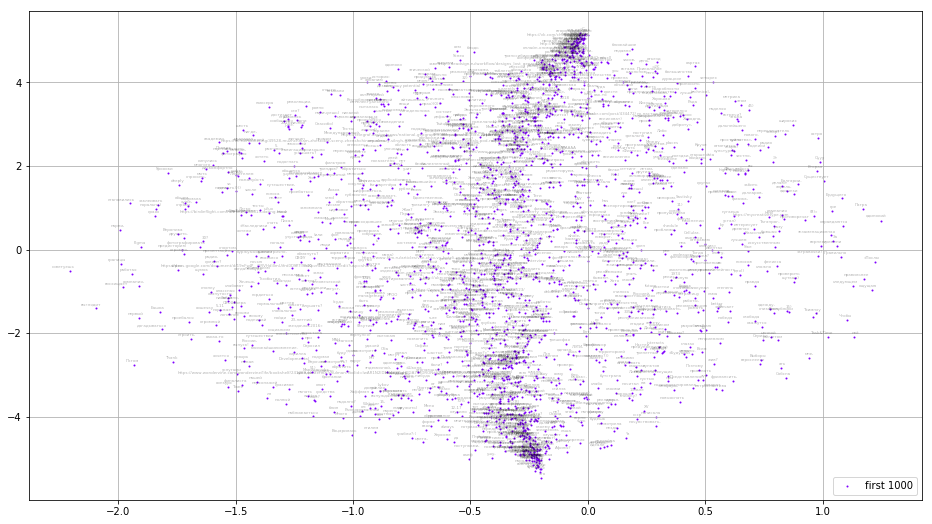

In [129]:

tsne_plot_2d('first 1000', Y, words.reshape(-1))

In [121]:
%matplotlib inline

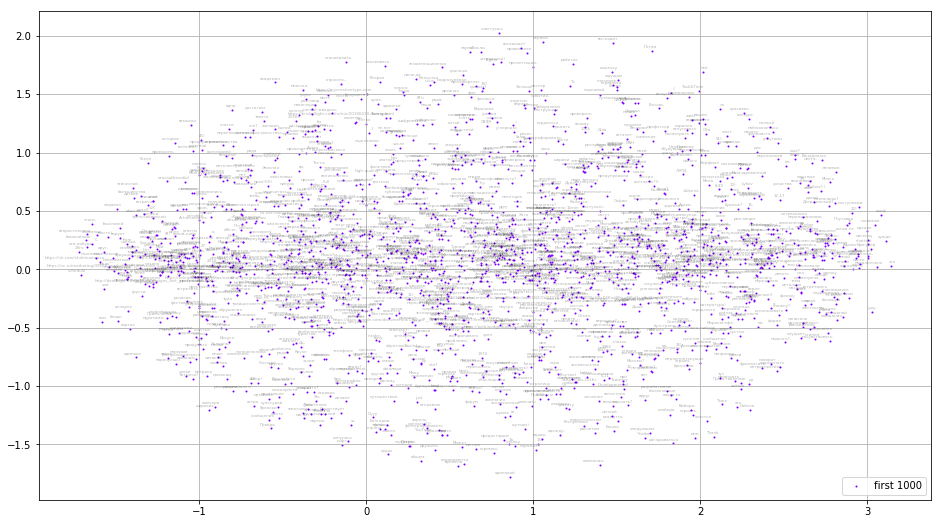

In [122]:

tsne_plot_2d('first 1000', Y, words.reshape(-1))